# MPC for Path Following

The core of the Path Follower algorithm is built upon three steps: **Trajectory Generation**, and **Control Calculation**. These steps work together to ensure that the vehicle follows the desired path smoothly and can stop appropriately when the end of the path is reached.

## Trajectory Generation
The trajectory is populated only once at the beginning of the simulation. 

The `populate_trajectory` function generates a smooth reference path by calculating spline-based coordinates from given waypoints. It appends each point's position (`x`, `y`), orientation (`yaw`), curvature (`k`), and a reference velocity that adheres to acceleration and speed limits to the trajectory. Control inputs, including steering and acceleration are also added. Finally, it smooths the velocity profile using a Gaussian filter to ensure realistic speed transitions along the path.

## Control Calculation

The `compute_optimal_input` function is responsible for determining the optimal control actions to guide the vehicle along the trajectory. It consists of two substeps:

### 1. Trajectory Fetching
The function `fetch_reference` fetches the correct reference states and control inputs to send to the MPC controller by advancing along the trajectory $\mathcal{T}$ starting from the point closest to the current state $x_i$, with curvilinear coordinate $s_c$. For each of the $N$ steps, it updates $s_c \gets s_c + v(s_c) \cdot \Delta t$. If $s_c$ remains within the trajectory bounds, it appends the corresponding state $\mathcal{T}.\text{state}(s_c)$ to $X$ and control input $\mathcal{T}.\text{input}(s_c)$ to $U$. If $s_c$ exceeds the trajectory limits, it sets a stop flag to indicate that the vehicle should stop.

<img src="https://github.com/lucjer/mpc_project/blob/master/readme_imgs/path_follower_algorithm.png?raw=true" width="600" />

Below is a visualization of the algorithm for fetching the trajectory at each time step. The distance between a point and the subsequent point to be fetched depends on the speed of the reference trajectory at that point.

<img src="https://github.com/lucjer/mpc_project/blob/master/readme_imgs/fetched_trajectory.png?raw=true" width="600" />

### 2. Nonlinear Model Predictive Control (NMPC) Solving
Once the reference states and inputs are fetched, the `compute_optimal_input` function uses a Nonlinear Model Predictive Control (NMPC) solver to calculate the optimal control inputs. If the vehicle is not in the stopping phase, it retrieves the reference states and inputs from the trajectory and uses the MPC controller to compute the optimal input. If the vehicle is in the stopping phase, it adjusts the MPC's state cost matrix to prioritize stopping.



In [99]:
# Import all necessary libraries
import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import sparse

import vehicle_dynamics.vehicle_models as vm 
import nonlinearmpcsolver as mpc
import utils
import vehicle_dynamics.path_follower as pf 


# Path Definition and Visualization

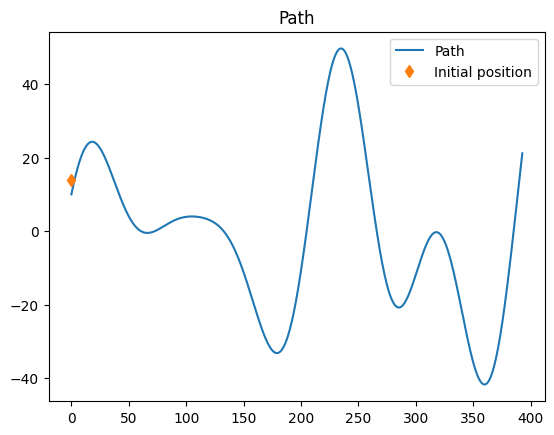

In [100]:
# Definition of sample path
x_ref = np.linspace(0, 125 * np.pi, 1000)
y_ref = np.sin(x_ref/50 * np.pi ) * 20 - np.sin(x_ref/80 * np.pi ) * 20 + np.cos(x_ref/40 * np.pi ) * 10 + np.sin(x_ref/90 * np.pi ) * 30


# Deffinition of the initial state
current_state = np.array([0., 14., np.pi/4, 8.0])

# Plot of the path
plt.plot(x_ref, y_ref, label='Path')
plt.plot(current_state[0], current_state[1], 'd', label='Initial position')
plt.title('Path')
plt.legend(loc='best')
plt.show()

# Initialize MPC Controller and Path Follower

In [101]:
model_kin = vm.KinematicBicycleVariableSpeed('config_files/mpc_bicycle_velocity_config.yaml') 
n_horizon = 25
Q = sparse.diags([1, 1, 20, 20]) # State cost matrix
R = sparse.diags([0.5, 0.25]) # Input cost matrix

# Define the input constraints and State constraints (states unconstrained currently)
u_min_acc = -4.5
u_max_acc = 4.5
delta_min = -np.pi/5
delta_max = np.pi/5

InputConstraints = {'umin': [delta_min, u_min_acc], 
                    'umax': [delta_max, u_max_acc]}

StateConstraints = {'xmin': np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
                    'xmax': np.array([np.inf, np.inf, np.inf, np.inf])}

# Define the MPC controller
mpc_controller = mpc.NMPCSolver(model=model_kin, N=n_horizon, Q=Q, R=R,
                             StateConstraints=StateConstraints,
                             InputConstraints=InputConstraints,
                             sqp_iters = 5,
                             alpha = 0.2,
                             debug_plotting_callback=utils.plot_xref_evolution,
                             debug_plots_folder='debug_plots/') 

# Define the path follower
path_follower = pf.PathFollower({'x': x_ref, 'y': y_ref}, mpc_controller,
                                search_radius=None,
                                sigma=800, maximum_velocity=15,
                                maximum_lateral_acceleration=2)

# Populate the trajectory with the reference path and the velocity profile - Refer to README for more details
path_follower.populate_trajectory() 

# Simulation

In [102]:
# Ensure the debug directory exists
debug_dir = 'debug_plots'
if not os.path.exists(debug_dir):
    os.makedirs(debug_dir)


# INITIALIZE SIMULATION
state_history = [current_state]
input_history = []
n_sim = 0
t_sim = [0]
debug = False


# Initialize lists to store velocities
vehicle_velocities = []
reference_velocities = []

stopping_condition = False

while not stopping_condition:
    # Stop the simulation when the vehicle reaches the end of the path
    stopping_condition = path_follower.stopping and current_state[3]<0.05    
    debug = False
    if n_sim % 150 == 0: 
        debug = False # Set to True if you want to analyze the debug plots
    
    # Compute optimal input and step the simulation 
    optimal_input = path_follower.compute_optimal_input(current_state, debug=debug)
    current_state = model_kin.step_nonlinear_model(current_state, optimal_input[0])  
    # TODO: Test the MPC controller with model mismatch and measurement disturbances

    input_history.append(optimal_input[0])
    state_history.append(current_state)
    vehicle_velocities.append(current_state[3])
    t_sim.append(t_sim[-1] + model_kin.mpc_params['dt'])

    # Find the closest index on the reference trajectory - Used for evaluation of velocity tracking
    closest_index = path_follower.find_closest_index(current_state, path_follower.trajectory,
                                                      start_index=path_follower.current_index,
                                                      search_radius=path_follower.search_radius)

    # Record the reference velocity at the closest index
    reference_velocities.append(path_follower.trajectory['v'][closest_index])

    # Plot fetched trajectory and input comparison
    if debug and not path_follower.stopping:
        path_follower.plot_fetched_trajectory_and_input(current_state, optimal_input, n_sim)
        input()
    
    n_sim += 1    

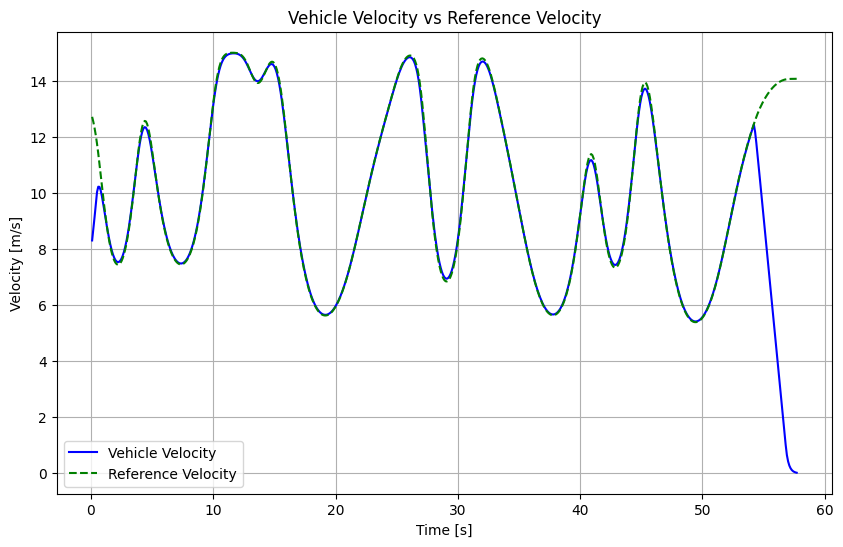

In [103]:
# Ensure the 'simulations' directory exists
output_dir = 'simulations'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Prepare states and inputs for plotting - Velocity Tracking
x_traj = [state_history[i][0] for i in range(n_sim)]
y_traj = [state_history[i][1] for i in range(n_sim)]
theta_traj = [state_history[i][2] for i in range(n_sim)]
v_traj = [state_history[i][3] for i in range(n_sim)]

delta_input = [inp[0] for inp in input_history]
acc_input = [inp[1] for inp in input_history]


plt.figure(figsize=(10, 6))
plt.plot(t_sim[1:], vehicle_velocities, label='Vehicle Velocity', color='blue')
plt.plot(t_sim[1:], reference_velocities, label='Reference Velocity', color='green', linestyle='--')
plt.title("Vehicle Velocity vs Reference Velocity")
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.legend()

plt.grid(True)
plt.savefig('simulations/velocity_comparison.pdf')
plt.show()



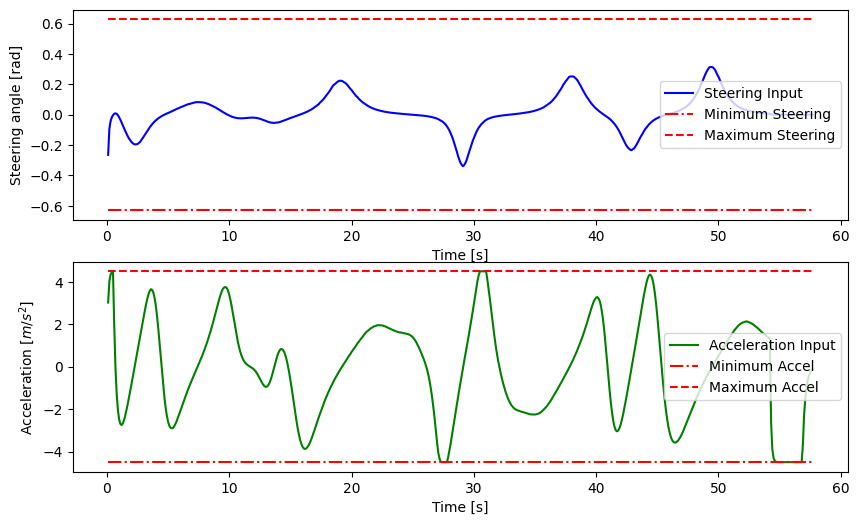

In [104]:
# Prepare states and inputs for plotting - Control input history

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(t_sim[1:], delta_input, label='Steering Input', color='blue')
plt.plot(t_sim[1:], [delta_min]*len(input_history), label='Minimum Steering', color='red', linestyle='dashdot')
plt.plot(t_sim[1:], [delta_max]*len(input_history), label='Maximum Steering', color='red', linestyle='--') 
plt.xlabel("Time [s]")
plt.ylabel("Steering angle [rad]")

plt.legend()
plt.subplot(2, 1, 2)
plt.plot(t_sim[1:], acc_input, label='Acceleration Input', color='green')
plt.plot(t_sim[1:], [u_min_acc]*len(input_history), label='Minimum Accel', color='red', linestyle='dashdot')
plt.plot(t_sim[1:], [u_max_acc]*len(input_history), label='Maximum Accel', color='red', linestyle='--')
plt.xlabel("Time [s]")
plt.ylabel(r"Acceleration [$m/s^2$]")


plt.savefig('simulations/input_comparison.pdf')
plt.legend(loc='best')
plt.show()




MovieWriter imagemagick unavailable; using Pillow instead.


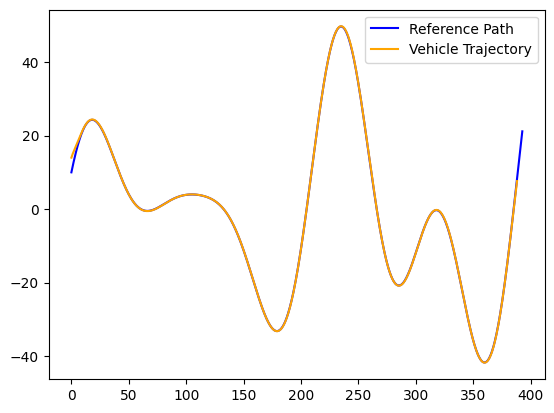

In [105]:
# Path tracking animation
fig, ax = plt.subplots()
ax.plot(x_ref, y_ref, color='blue', label='Reference Path')  # Reference trajectory
line, = ax.plot([], [], color='orange', label='Vehicle Trajectory')  # Trajectory line

# Add legend
ax.legend(loc='upper right')

def init():
    line.set_data([], [])
    return line,

def update(frame):
    line.set_data(x_traj[:frame], y_traj[:frame])
    return line,

ani = animation.FuncAnimation(fig, update, frames=n_sim, init_func=init, blit=True, interval=12)  # Set a faster frame interval

# Save the animation with a higher FPS to speed up the GIF
ani.save(os.path.join(output_dir, 'trajectory_animation.gif'), writer='imagemagick', fps=30)

In [106]:
n_sim

577